In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams
%matplotlib inline

In [ ]:
# For reproducibility of Seaborn

sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

In [2]:
# Upload the dataset
math_df = pd.read_csv("./student-mat.csv", sep=",")
port_df = pd.read_csv("./student-por.csv", sep=",")

math_df["course"] = "math"
port_df["course"] = "portuguese"

merged_df = math_df.append(port_df)
merged_df.shape

(1044, 34)

In [3]:
# See if there is duplicates
merge_vector = ["school","sex","age","address",
                "famsize","Pstatus","Medu","Fedu",
                "Mjob","Fjob","reason","nursery","internet"]

duplicated_mask = merged_df.duplicated(keep=False, subset=merge_vector)
duplicated_df = merged_df[duplicated_mask]
unique_df = merged_df[~duplicated_mask]
both_courses_mask = duplicated_df.duplicated(subset=merge_vector)
both_courses_df = duplicated_df[~both_courses_mask].copy()
both_courses_df["course"] = "both"
students_df = unique_df.append(both_courses_df)

In [4]:
# Divide the students between drinkers and non-drinkers

students_df = students_df.sample(frac=1)
students_df['alcohol'] = (students_df.Walc * 2 + students_df.Dalc * 5) / 7
students_df['alcohol'] = students_df.alcohol.map(lambda x: ceil(x))
students_df['drinker'] = students_df.alcohol.map(lambda x: "yes" if x > 2 else "no")

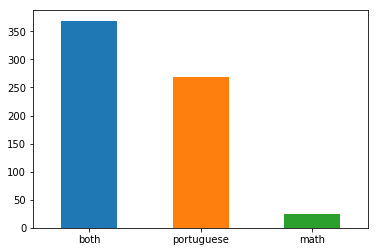

In [5]:
students_df.course.value_counts().plot(kind="bar", rot=0)

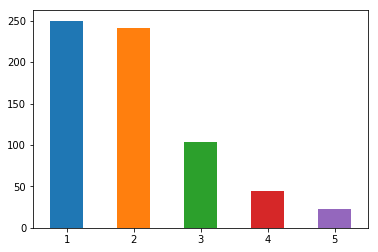

In [6]:
students_df.alcohol.value_counts().plot(kind="bar", rot=0)

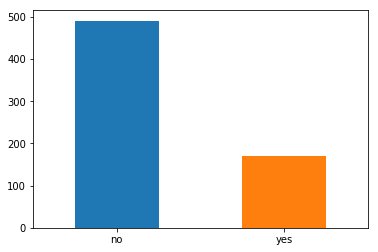

In [7]:
students_df.drinker.value_counts().plot(kind="bar", rot=0)

C:\ProgramData\Anaconda3\envs\modelTest\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


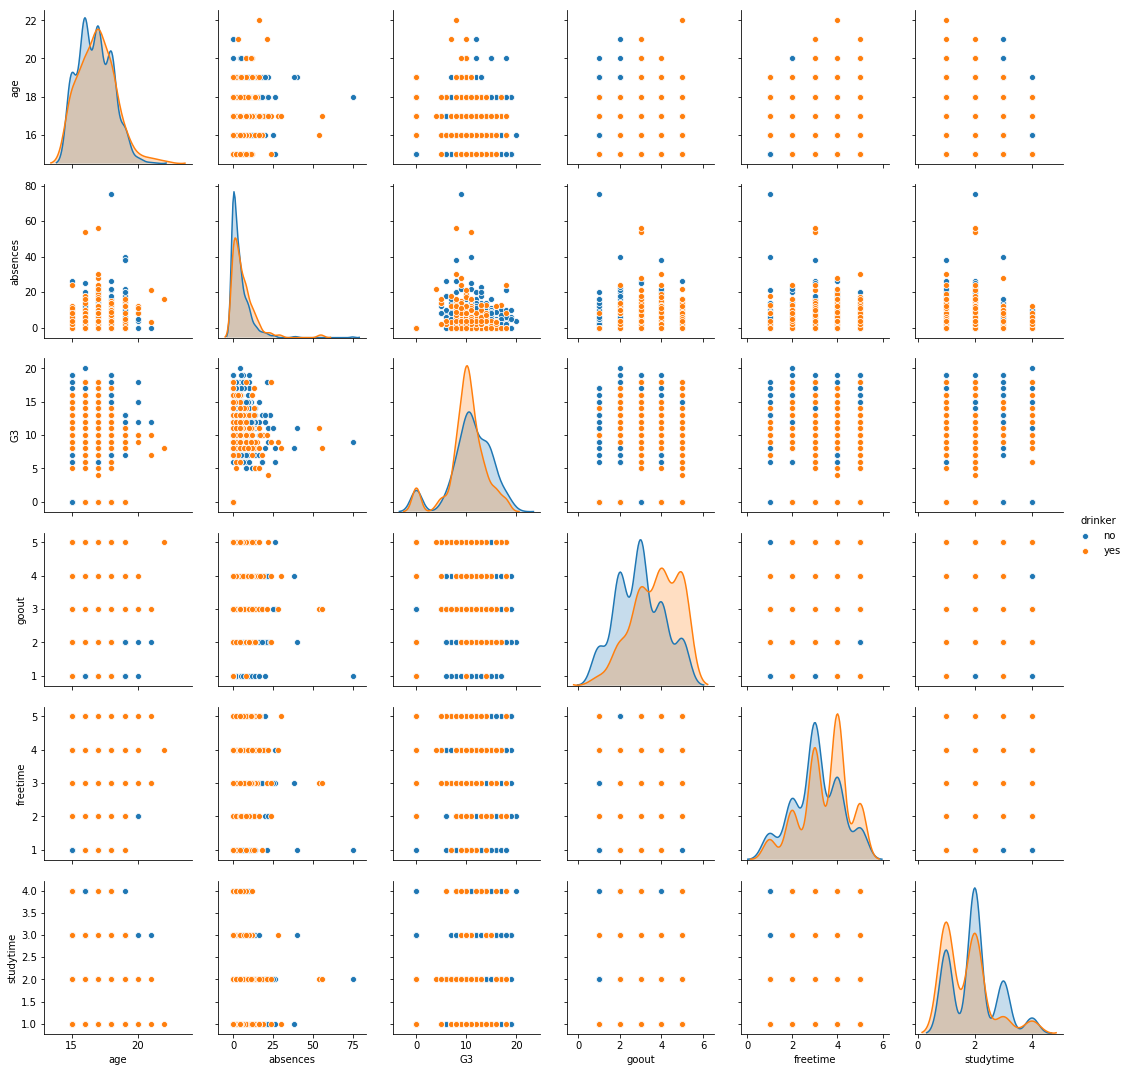

In [8]:
sns.pairplot(students_df[['age','absences','G3','goout','freetime','studytime','drinker']], hue='drinker');

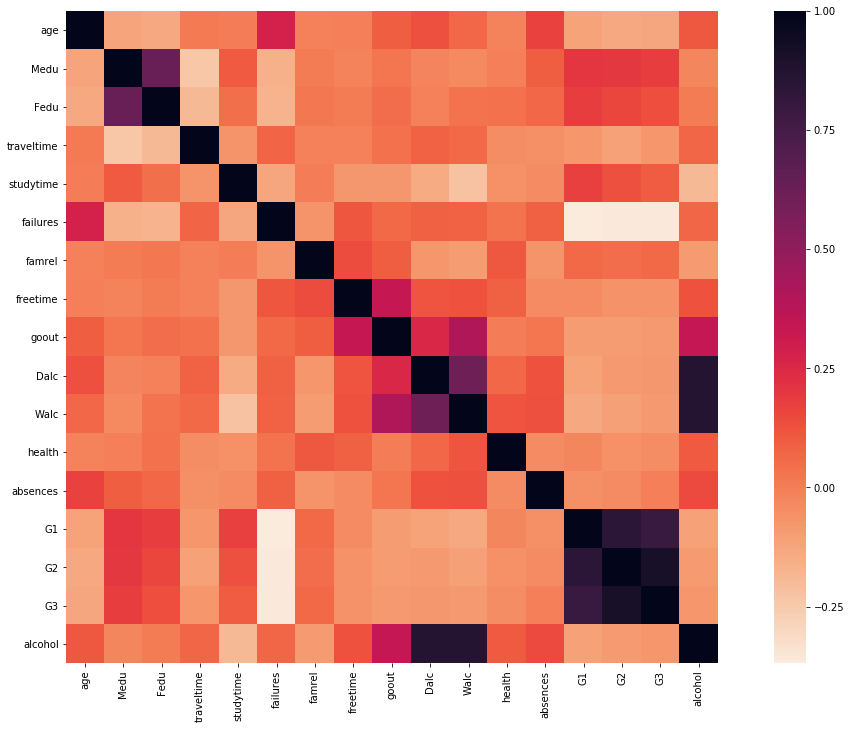

In [11]:
# General look on correlation matrix
corr_mat = students_df.corr()
fig, ax = plt.subplots(figsize=(20,12))

# Reverse colors
cmap = sns.cm.rocket_r
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax, cmap=cmap);

In [16]:
def encode(series):
    return pd.get_dummies(series.astype(str))

In [18]:
train_x = pd.get_dummies(students_df.school)
train_x['age'] = students_df.age
train_x['absences'] = students_df.absences
train_x['g1'] = students_df.G1
train_x['g2'] = students_df.G2
train_x['g3'] = students_df.G3
train_x = pd.concat([train_x, encode(students_df.sex), encode(students_df.Pstatus), 
                     encode(students_df.Medu), encode(students_df.Fedu),
                     encode(students_df.guardian), encode(students_df.studytime),
                     encode(students_df.failures), encode(students_df.activities),
                     encode(students_df.higher), encode(students_df.romantic),
                     encode(students_df.reason), encode(students_df.paid),
                     encode(students_df.goout), encode(students_df.health),
                     encode(students_df.famsize), encode(students_df.course)
                    ], axis=1)
train_y = encode(students_df.drinker)


In [22]:
# Splitting the data 90% for training and 10% for testing

train_size = 0.9

train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

In [24]:
def multilayer_perceptron (x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out'] + biases['out'])
    return out_layer

In [27]:
n_hidden_1 = 38
n_input = train_x.shape[1]
n_classes = train_y.shape[1]

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1], n_classes))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
keep_prob = tf.placeholder("float")

In [36]:
training_epochs = 5000
display_step = 1000
batch_size = 32

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

In [34]:
train_y.shape

(662, 2)